In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import ELU, PReLU, LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
import statistics

In [30]:
# VARIAVEIS GERAIS

batch_size = 16

# dataset = "Originais"

# dataset = "ref1/ED"
# dataset = "ref1/KL"
# dataset = "ref1/Li"
# dataset = "ref1/Perez-Bueno"
# dataset = "ref1/Renyi"
# dataset = "ref1/Tosta"
# dataset = "ref1/Vahadane"

# dataset = "ref2/ED"
# dataset = "ref2/KL"
# dataset = "ref2/Li"
# dataset = "ref2/Perez-Bueno"
# dataset = "ref2/Renyi"
# dataset = "ref2/Tosta"
# dataset = "ref2/Vahadane"

# dataset = "ref3/ED"
dataset = "ref3/KL"
# dataset = "ref3/Li"
# dataset = "ref3/Perez-Bueno"
# dataset = "ref3/Renyi"
# dataset = "ref3/Tosta"
# dataset = "ref3/Vahadane"

In [31]:
class ProtoSeg(nn.Module):
    def __init__(self,ndims='2d'):
        super().__init__()

        # for 1D: self.dims=(2)
        # for 2D image: self.dims=(2,3)
        # for 3D image: self.dims=(2,3,4)
        if ndims == '1d':
            self.dims = (2)
        elif ndims == '2d':
            self.dims = (2,3)
        elif ndims == '3d':
            self.dims = (2,3,4)
        else:
            raise ValueError('ndims must be in [1d,2d,3d]')

        self.softmax = nn.Softmax(dim=1)

    def forward(self,xfeat,pred,mask=None):
        #@ xfeat: the deep feature need to be inperpreted
        #@ pred: the initial segmentation results from the last layer of the network
        #@ mask is to maks out the background of the image (without any tissue)

        if mask is not None:
            pos_prototype = torch.sum(xfeat*pred*mask,dim=self.dims,keepdim=True)
            num_prototype = torch.sum(pred*mask,dim=self.dims,keepdim=True)
            pos_prototype = pos_prototype / num_prototype

            rpred = 1 - pred

            neg_prototype = torch.sum(xfeat*rpred*mask,dim=self.dims,keepdim=True)
            num_prototype = torch.sum(rpred*mask,dim=self.dims,keepdim=True)
            neg_prototype = neg_prototype / num_prototype

            pfeat = -torch.pow(xfeat-pos_prototype,2).sum(1,keepdim=True)
            nfeat = -torch.pow(xfeat-neg_prototype,2).sum(1,keepdim=True)

            disfeat = torch.cat([nfeat,pfeat],dim=1)
            pred = self.softmax(disfeat)

        else:
            pos_prototype = torch.sum(xfeat*pred,dim=self.dims,keepdim=True)
            num_prototype = torch.sum(pred,dim=self.dims,keepdim=True)
            pos_prototype = pos_prototype / num_prototype

            rpred = 1 - pred

            neg_prototype = torch.sum(xfeat*rpred,dim=self.dims,keepdim=True)
            num_prototype = torch.sum(rpred,dim=self.dims,keepdim=True)
            neg_prototype = neg_prototype / num_prototype

            pfeat = -torch.pow(xfeat-pos_prototype,2).sum(1,keepdim=True)
            nfeat = -torch.pow(xfeat-neg_prototype,2).sum(1,keepdim=True)

            disfeat = torch.cat([nfeat,pfeat],dim=1)
            pred = self.softmax(disfeat)

        return pred

In [32]:
def dice_score(mask_true, mask_pred):
    mask_true = tf.cast(mask_true, tf.float32)
    mask_pred = tf.cast(mask_pred, tf.float32)
    intersection = tf.reduce_sum(mask_true * mask_pred)
    dice = (2.0 * intersection) / (tf.reduce_sum(mask_true) + tf.reduce_sum(mask_pred))
    return dice

@keras.saving.register_keras_serializable()
def SA_score(y_true, y_pred): # images, masks, outputs, feature_extractor

    img = current_X
    mask = y_true
    output = current_Y

    feature_extractor = Model(
       inputs=model.inputs,
       outputs=model.layers[-1].output,
    )

    x = tf.reshape(img, (1, 256, 256, 3))
    features = feature_extractor(x)
    x = tf.transpose(features, (0, 3, 1, 2))

    pred_map = tf.transpose(output, (2, 0, 1))
    pred_map = tf.reshape(pred_map, (1, 1, 256, 256))

    shape = int(x.shape[2])

    if shape != 256:
        x = tf.image.resize(x, size=(256, 256), method='bilinear')

    neters = ProtoSeg(ndims='2d')
    probability_map = neters(x, pred_map, mask=None)
    binary_map = tf.argmax(probability_map, 1)

    bmap = tf.transpose(binary_map, (1, 2, 0))

    sa_score = dice_score(mask, bmap)

    return sa_score

In [33]:
@keras.saving.register_keras_serializable()
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

@keras.saving.register_keras_serializable()
def custom_loss(y_true, y_pred):
    # Exemplo simples: entropia cruzada binária
    sa_score = SA_score(y_true, y_pred)

    if K.any(tf.math.is_nan(sa_score)):
        sa_score = tf.constant(0, dtype=tf.float32)
        #sa_score = tf.constant(1e10)
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.add(loss, sa_score)

In [34]:
from random import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image
import cv2

current_X = {}
current_Y = {}

def image_generator(group, files, batch_size = 4, sz = (256, 256), mendeley=False):
    global current_X, current_Y

    while True:
        #extract a random batch
        batch = np.random.choice(files, size = batch_size)

        #variables for collecting batches of inputs and outputs
        batch_x = []
        batch_y = []

        for f in batch:

            #get the masks. Note that masks are png files
            mask = Image.open(f'datasets/{dataset}/{group}/mascaras/{f}.png')

            mask = np.array(mask.resize(sz))
            mask = np.expand_dims(mask, axis=-1)

            #preprocess the mask
            mask[mask > 0] = 1
            batch_y.append(mask)

            # Carregar a imagem
            raw = cv2.imread(f'datasets/{dataset}/{group}/{f}.png')
            raw = cv2.resize(raw, sz)
            raw = np.array(raw)

            #check the number of channels because some of the images are RGBA or GRAY
            if len(raw.shape) == 2:
              raw = np.stack((raw,)*3, axis=-1)

            raw = raw[:, :, 0:3]

            batch_x.append(raw)

        #preprocess a batch of images and masks
        batch_x = np.array(batch_x)/255.
        batch_y = np.array(batch_y)
        #batch_y = np.expand_dims(batch_y,3)

        #current_X = batch_x[0]
        #current_Y = batch_y[0]

        current_X = batch_x
        current_Y = batch_y

        yield (batch_x, batch_y)

In [35]:
import os

all_files = []

test_files = list(os.path.splitext(file)[0] for file in os.listdir(f'datasets/{dataset}/test') if os.path.isfile(os.path.join(f'datasets/{dataset}/test', file)))

test_generator  = image_generator("test", test_files, batch_size = batch_size)

In [36]:
def dice_score(mask_true, mask_pred):
    intersection = np.sum(mask_true * mask_pred)
    dice = (2.0 * intersection) / (np.sum(mask_true) + np.sum(mask_pred))
    return dice

In [37]:
def get_SA_scores(images, masks, outputs, feature_extractor):
    '''
    images: imagens originais
    masks: mascaras originais
    outputs: mascaras geradas pelo modelo
    '''

    sa_scores = []

    for i in range(0, len(images)):

        img = images[i]

        mask = masks[i]
        output = outputs[i]

        x = img.reshape((1, 256, 256, 3))
        features = feature_extractor(x)
        x = np.transpose(features, (0, 3, 1, 2))
        x = torch.from_numpy(x)

        pred_map = np.transpose(output, (2, 0, 1))
        pred_map = pred_map.reshape((1, 1, 256, 256))
        pred_map = torch.from_numpy(pred_map)

        shape = int(x.shape[2])

        if shape != 256:
            x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)

        neters = ProtoSeg(ndims='2d')
        probability_map = neters(x, pred_map, mask=None)
        binary_map = torch.argmax(probability_map, 1)

        bmap = np.transpose(np.asarray(binary_map), (1, 2, 0))

        sa_score = dice_score(mask, bmap)
        sa_scores.append(sa_score)

    return sa_scores

In [38]:
from keras.models import load_model

custom_objects = {"mean_iou": mean_iou}
modelos = [f"Unet_{dataset.replace('/', '_')}", f"Unet_Protoseg_{dataset.replace('/', '_')}"]

camadas_modelos = []
medias_modelos = []
desvios_modelos = []

In [39]:
for j in range(0, 10):

  for modelo in modelos:
      with keras.saving.custom_object_scope(custom_objects):
          model = load_model(f"saida/modelos_salvos/{modelo}.h5")

      images, masks = next(test_generator)

      masks_teste = model.predict(images)
      print("Shape Classes:", masks_teste.shape)

      camadas = []
      medias  = []
      desvios = []

      for i in range(0, len(model.layers)):
          layer = str(model.layers[i])
          if "Conv2D" in layer and not "transpose" in layer:
              if "relu" in str(model.layers[i].activation) or "sigmoid" in str(model.layers[i].activation):
                  feature_extractor = Model(
                    inputs=model.inputs,
                    outputs=model.layers[i].output,
                  )

                  scores = get_SA_scores(images, masks, masks_teste, feature_extractor)

                  if len(scores) > 0:
                      media = statistics.mean(scores)
                      desvio_padrao = statistics.stdev(scores)

                      camadas.append(i)
                      medias.append(media)
                      desvios.append(desvio_padrao)

      if j == 0:
        camadas_modelos.append(camadas)
      medias_modelos.append(medias)
      desvios_modelos.append(desvios)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
Shape Classes: (16, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
Shape Classes: (16, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
Shape Classes: (16, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
Shape Classes: (16, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
Shape Classes: (16, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
Shape Classes: (16, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
Shape Classes: (16, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
Shape Classes: (16, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
Shape Classes: (16, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
Shape Classes: (16, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
Shape Classes: (16, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
Shape Classes: (16, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
Shape Classes: (16, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
Shape Classes: (16, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Shape Classes: (16, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
Shape Classes: (16, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
Shape Classes: (16, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
Shape Classes: (16, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
Shape Classes: (16, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
Shape Classes: (16, 256, 256, 1)


In [40]:
def calcula_media(lista):

  # Separar listas de índices pares e ímpares
  pares = lista[::2]
  impares = lista[1::2]

  # Calcular médias
  media_pares = np.mean(pares, axis=0)
  media_impares = np.mean(impares, axis=0)

  return [media_pares.tolist(), media_impares.tolist()]

medias_modelos = calcula_media(medias_modelos)
desvios_modelos = calcula_media(desvios_modelos)

In [41]:
print(len(camadas_modelos[0]))

camadas = list(range(1, len(camadas_modelos[0]) + 1))

print(camadas)

19
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


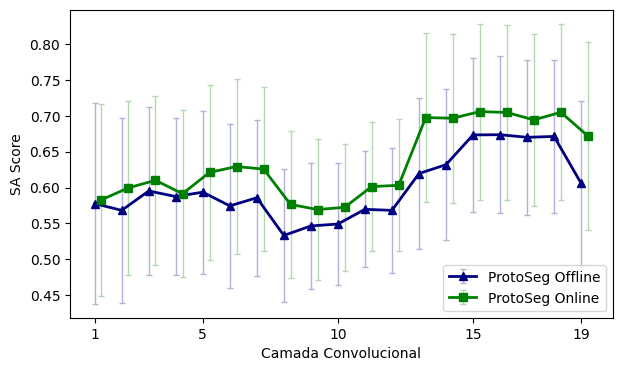

Unet_Protoseg_ref3_KL


In [42]:
icones = ['-^', '-s']
ecores = ['#b2b2d9', '#b2d9b2']
cores = ['#000080', '#008000']
labels = ['ProtoSeg Offline', 'ProtoSeg Online']

line_style = {'alpha': 0.5}
icon_style = {}

fig, ax = plt.subplots(figsize=(7, 4))

for i in range(len(medias_modelos)):
    plt.errorbar(list(map(lambda x: x + (0.25*i), camadas)),
                 medias_modelos[i], yerr=desvios_modelos[i],
                 fmt=icones[i], capsize=2, elinewidth=1, linewidth=2, ecolor=ecores[i], color=cores[i], label=labels[i])

plt.xlabel('Camada Convolucional')
plt.ylabel('SA Score')
#plt.title('Gráfico com Desvios Padrão')
plt.legend(loc="lower right")

plt.xticks([1, 5, 10, 15, len(camadas_modelos[0])])


plt.savefig(f"saida/imagens/Camadas_{modelo}.svg")
plt.savefig(f"saida/imagens/Camadas_{modelo}.png")

plt.show()
print(modelo)